## Setup

In [1]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from absl import logging
logging.set_verbosity(logging.ERROR)

In [2]:
print('\u2022 Using TensorFlow Version:', tf.__version__)
print('\u2022 GPU Device Found.' if tf.config.list_physical_devices('GPU') else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.7.0
• GPU Device Found.


## Read the processed data into the training dataset and validation dataset
The data in this directory has been previously cleaned, which finally obtained a dataset of 350 images in each class which is divided into 2 directories in the training directory as much as 80% or 280 images in each class and in the Validation or Test data as much as 20% or 70 images in each class.

In [3]:
TRAINING_DIR = "train_dir/"
VALIDATION_DIR = "validation_dir/"

In [4]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    train_datagen = ImageDataGenerator(rescale= 1./255.,
                                        rotation_range=180,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,             
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        fill_mode='nearest',
                                        horizontal_flip=True,
                                        vertical_flip=True)
    
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=32,
                                                        class_mode="categorical",
                                                        target_size=(224, 224))

    
    validation_datagen = ImageDataGenerator(rescale=1./255.)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                  batch_size=32,
                                                                  class_mode="categorical",
                                                                  target_size=(224, 224))
    
    return train_generator, validation_generator

In [5]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 5600 images belonging to 20 classes.
Found 1400 images belonging to 20 classes.


In [6]:
label_names = list(validation_generator.class_indices.keys())
print(f"{label_names} \nClass : {len(label_names)}")

['American_shorthair', 'Basset_hound', 'Beagle', 'Bengal', 'Boxer', 'British_Shorthair', 'Chihuahua', 'English_cocker_spaniel', 'Japanese_chin', 'Maine_Coon', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian_Blue', 'Samoyed', 'Scottish_fold', 'Siamese', 'Sphynx'] 
Class : 20


In [7]:
def plotImages(images_arr, folder_names):
    fig, axes = plt.subplots(1, 5, figsize=(10, 10))
    axes = axes.flatten()
    for img, folder_name, ax in zip(images_arr, folder_names, axes):
        ax.imshow(img[:, :, 0])
        ax.axis('off')
        ax.set_title(folder_name)
    plt.tight_layout()
    plt.show()

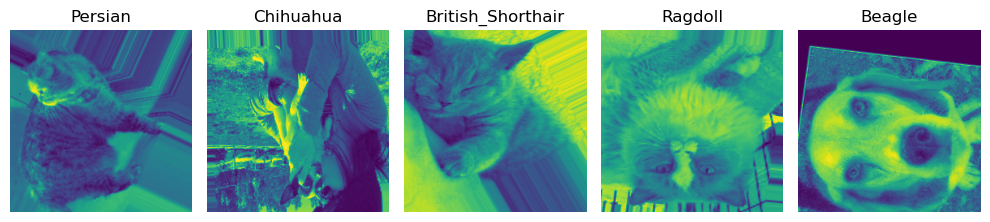

In [8]:
sample_training_images, labels = next(train_generator)
folder_names = [list(train_generator.class_indices.keys())[label.argmax()] for label in labels]

plotImages(sample_training_images[:5], folder_names)

## Creating a Callback class

In [9]:
class cb(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.90 and logs.get('val_accuracy') > 0.90):
            print("\nAccuracy has reached above 90%, training stops")
            self.model.stop_training = True # training will stop when accuracy and val_accuracy have reached >= 90%

callbacks = cb()

## Define, compile and Train the model

In [10]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


In [11]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE])

In [12]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),     
        tf.keras.layers.Dense(20,activation='softmax') 
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', 
              metrics=['accuracy']) 

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 20)                2

In [14]:
# Train the model
history = model.fit(train_generator,
                    epochs=200,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[callbacks]
                   )

Epoch 1/200
175/175 [==============================] - 93s 499ms/step - loss: 1.8479 - accuracy: 0.4614 - val_loss: 0.7949 - val_accuracy: 0.7771
Epoch 2/200
175/175 [==============================] - 58s 332ms/step - loss: 1.1237 - accuracy: 0.6346 - val_loss: 0.6297 - val_accuracy: 0.8157
Epoch 3/200
175/175 [==============================] - 59s 335ms/step - loss: 1.0093 - accuracy: 0.6643 - val_loss: 0.6006 - val_accuracy: 0.8164
Epoch 4/200
175/175 [==============================] - 58s 331ms/step - loss: 0.9228 - accuracy: 0.6866 - val_loss: 0.5935 - val_accuracy: 0.8057
Epoch 5/200
175/175 [==============================] - 58s 334ms/step - loss: 0.8904 - accuracy: 0.7048 - val_loss: 0.5533 - val_accuracy: 0.8200
Epoch 6/200
175/175 [==============================] - 59s 338ms/step - loss: 0.8416 - accuracy: 0.7214 - val_loss: 0.5387 - val_accuracy: 0.8400
Epoch 7/200
175/175 [==============================] - 58s 333ms/step - loss: 0.8239 - accuracy: 0.7241 - val_loss: 0.5510 -

Epoch 57/200
175/175 [==============================] - 64s 364ms/step - loss: 0.3486 - accuracy: 0.8761 - val_loss: 0.5932 - val_accuracy: 0.8314
Epoch 58/200
175/175 [==============================] - 63s 358ms/step - loss: 0.3442 - accuracy: 0.8766 - val_loss: 0.5967 - val_accuracy: 0.8300
Epoch 59/200
175/175 [==============================] - 62s 353ms/step - loss: 0.3449 - accuracy: 0.8727 - val_loss: 0.5664 - val_accuracy: 0.8400
Epoch 60/200
175/175 [==============================] - 62s 356ms/step - loss: 0.3379 - accuracy: 0.8820 - val_loss: 0.5789 - val_accuracy: 0.8400
Epoch 61/200
175/175 [==============================] - 63s 358ms/step - loss: 0.3361 - accuracy: 0.8786 - val_loss: 0.5620 - val_accuracy: 0.8329
Epoch 62/200
175/175 [==============================] - 64s 366ms/step - loss: 0.3421 - accuracy: 0.8829 - val_loss: 0.6198 - val_accuracy: 0.8171
Epoch 63/200
175/175 [==============================] - 63s 362ms/step - loss: 0.3282 - accuracy: 0.8813 - val_loss: 0

175/175 [==============================] - 67s 380ms/step - loss: 0.1931 - accuracy: 0.9341 - val_loss: 0.6477 - val_accuracy: 0.8336
Epoch 113/200
175/175 [==============================] - 72s 408ms/step - loss: 0.1997 - accuracy: 0.9305 - val_loss: 0.6767 - val_accuracy: 0.8329
Epoch 114/200
175/175 [==============================] - 70s 402ms/step - loss: 0.2052 - accuracy: 0.9259 - val_loss: 0.6738 - val_accuracy: 0.8250
Epoch 115/200
175/175 [==============================] - 67s 384ms/step - loss: 0.1972 - accuracy: 0.9336 - val_loss: 0.7361 - val_accuracy: 0.8250
Epoch 116/200
175/175 [==============================] - 65s 374ms/step - loss: 0.1974 - accuracy: 0.9343 - val_loss: 0.6810 - val_accuracy: 0.8329
Epoch 117/200
175/175 [==============================] - 65s 371ms/step - loss: 0.2106 - accuracy: 0.9248 - val_loss: 0.7473 - val_accuracy: 0.8157
Epoch 118/200
175/175 [==============================] - 65s 373ms/step - loss: 0.1905 - accuracy: 0.9316 - val_loss: 0.7433 -

175/175 [==============================] - 66s 377ms/step - loss: 0.1471 - accuracy: 0.9471 - val_loss: 0.8067 - val_accuracy: 0.8250
Epoch 168/200
175/175 [==============================] - 66s 377ms/step - loss: 0.1406 - accuracy: 0.9530 - val_loss: 0.8536 - val_accuracy: 0.8179
Epoch 169/200
175/175 [==============================] - 66s 380ms/step - loss: 0.1487 - accuracy: 0.9486 - val_loss: 0.8089 - val_accuracy: 0.8243
Epoch 170/200
175/175 [==============================] - 63s 359ms/step - loss: 0.1414 - accuracy: 0.9488 - val_loss: 0.8450 - val_accuracy: 0.8214
Epoch 171/200
175/175 [==============================] - 63s 360ms/step - loss: 0.1343 - accuracy: 0.9516 - val_loss: 0.8366 - val_accuracy: 0.8250
Epoch 172/200
175/175 [==============================] - 63s 360ms/step - loss: 0.1358 - accuracy: 0.9546 - val_loss: 0.7668 - val_accuracy: 0.8421
Epoch 173/200
175/175 [==============================] - 64s 363ms/step - loss: 0.1306 - accuracy: 0.9566 - val_loss: 0.8491 -

### Evaluate the Model

In [15]:
# Evaluate the model on the test or validation images.
results_eval = model.evaluate(validation_generator)

for metric, value in zip(model.metrics_names, results_eval):
    print(metric + ': {:.3}'.format(value))

44/44 [==============================] - 4s 97ms/step - loss: 0.8350 - accuracy: 0.8321
loss: 0.835
accuracy: 0.832


### Training History

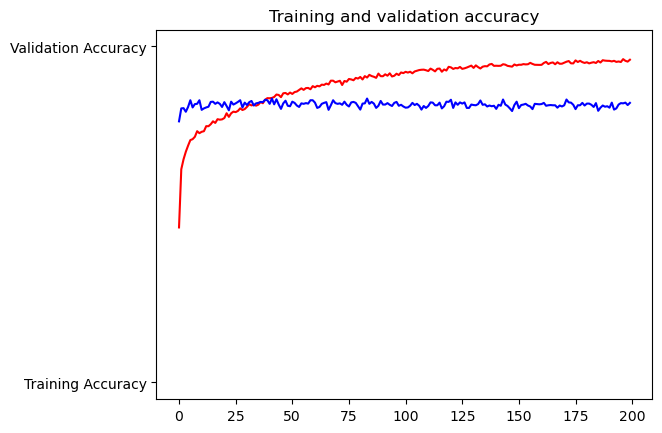

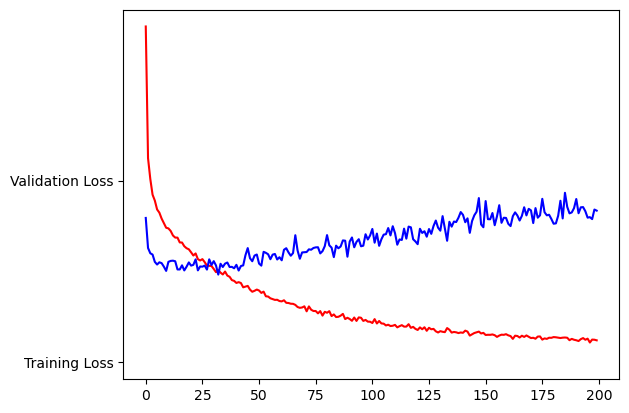

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

### Testing models with images that have never been used

In [79]:
def load_and_prep_image(filename, img_shape=224):
    # Read in target file (an image)
    img = tf.io.read_file(filename)
    
    # Decode the read file into a tensor & ensure 3 colour channels 
    # our model is trained on images with 3 colour channels 
    img = tf.image.decode_image(img, channels=3)
    
    # Resize the image (to the same size our model was trained on)
    img = tf.image.resize(img, size = [img_shape, img_shape])
    
    # Rescale the image (get all values between 0 and 1)
    img = img/255.
    return img
     

In [80]:
def pred_and_plot(model, filename, label_names):
    img = load_and_prep_image(filename)
    pred = model.predict(tf.expand_dims(img, axis=0))
    indeks_kolom = tf.where(tf.round(pred)[0] == 1)
    pred_class = label_names[int(indeks_kolom)]
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

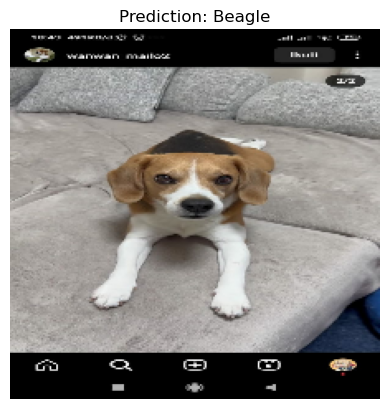

In [81]:
# Test our model on a custom image
pred_and_plot(model, "WhatsApp Image 2023-05-25 at 18.43.46.jpeg", label_names)

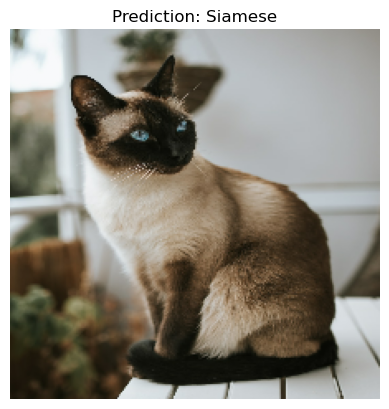

In [82]:
# Test our model on a custom image
pred_and_plot(model, "siamese_cat_2.jpg", label_names)

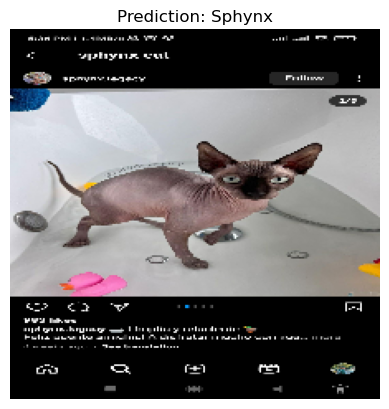

In [83]:
# Test our model on a custom image
pred_and_plot(model, "Screenshot_2023-05-26-17-36-11-408_com.instagram.android.jpg", label_names)

## save model format Keras HDF5

In [84]:
model.save('model_versike2_mobilenetv2.h5')

## Save model Exporting to TFLite

In [85]:
export_dir = 'saved_model/model_versike2_mobilenet_v2'

tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/model_versike2_mobilenet_v2\assets


INFO:tensorflow:Assets written to: saved_model/model_versike2_mobilenet_v2\assets


In [86]:
# Select mode of optimization
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [87]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [88]:
tflite_model_file = pathlib.Path('./model_versike2_mobilenet_v2.tflite')
tflite_model_file.write_bytes(tflite_model)

4556304